In [1]:
import tensorflow as tf
import numpy as np
import os
import sys

In [2]:
# Path para importacion de funciones
dir_actual    = os.path.abspath('')
dir_parent = os.path.dirname(dir_actual)
if not dir_parent in sys.path: sys.path.append(dir_parent)

## Loading CIFAR10 Data

In [3]:
(_, _), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# Normalizando
x_test = x_test/255.
# Reducing Target innecessary dimension
y_test  = np.squeeze(y_test)

## Creating Dataset Objects

In [4]:
from functions import to_categorical, AlexNet_resize

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.map(to_categorical)
test_dataset = test_dataset.map(AlexNet_resize)
test_dataset = test_dataset.batch(1)

## Loading Quantized model and Non Quantized model 

In [5]:
from models import AlexNet_body

input_layer   = tf.keras.Input((227,227,3))
output_layer  = AlexNet_body(input_layer, Quantization = False)

#For this example we using 8 bits of precision.
Qinput_layer  = tf.keras.Input((227,227,3))
Qoutput_layer = AlexNet_body(Qinput_layer, Quantization = True, word_size = 14, frac_size = 8)

AlexNet  = tf.keras.Model(inputs=input_layer, outputs=output_layer)
QAlexNet = tf.keras.Model(inputs=Qinput_layer, outputs=Qoutput_layer)

## Loading Pretrained Weights

In [6]:
# Loading Wieghts
cwd = os.getcwd()
Wgt_dir = os.path.join(cwd,'TrainedWeights')
Wgt_dir = os.path.join(Wgt_dir,'Weights')

AlexNet.load_weights(Wgt_dir)
QAlexNet.load_weights(Wgt_dir)

## Quantize weights

In [7]:
from models import Weight_Quantization
Weight_Quantization(model = QAlexNet, Frac_Bits = 8, Int_Bits = 5)

## Checking the model predictions

In [8]:
import time
import matplotlib.pyplot as plt

# Iterator over test Dataset
iterator  = iter(test_dataset)

Target: 8
Prediction: 8
QPrediction: 8


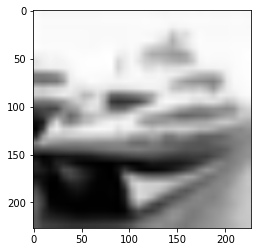

In [10]:
# Getting new image from iterator
image     = next(iterator)
image_plt = image[0][0,...,0]

# Plotting Test image
plt.imshow(image_plt, cmap='gray')

# Target
tf.print("Target:",np.argmax(image[1]))
# Predicted Output
print("Prediction:",np.argmax(AlexNet.predict(image[0])))
# Quantized Predicted Output
print("QPrediction:",np.argmax(QAlexNet.predict(image[0])))

## Comparation of Output

In [11]:
AlexNet.predict(image[0])

array([[3.8282457e-04, 1.6174544e-02, 8.0737692e-08, 4.0400658e-07,
        1.9318398e-09, 1.4480276e-08, 9.7161895e-08, 3.5751755e-09,
        9.8329306e-01, 1.4898156e-04]], dtype=float32)

In [12]:
QAlexNet.predict(image[0])

array([[0.       , 0.0078125, 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.9921875, 0.       ]], dtype=float32)

#### Classes

0. airplane
1. automobile
2. bird
3. cat
4. deer
5. dog
6. frog
7. horse
8. ship
9. truck

## Check the general Accuracy

In [13]:
# Optimization params
# -------------------

# Loss
loss = tf.keras.losses.CategoricalCrossentropy()

# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Validation metrics
# ------------------

metrics = ['accuracy']
# ------------------

# Compile Model
AlexNet.compile(optimizer=optimizer, loss=loss, metrics=metrics)
QAlexNet.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [89]:
AlexNet.evaluate(test_dataset)

10000/10000 [==============================] - 64s 6ms/step - loss: 0.6316 - accuracy: 0.7898


[0.6315659527876948, 0.7898]

In [90]:
QAlexNet.evaluate(test_dataset)

10000/10000 [==============================] - 63s 6ms/step - loss: 0.6723 - accuracy: 0.7935


[0.6723387817996089, 0.7935]

## Checking The Output of Each Layer

In [14]:
from functions import get_all_outputs
# List for layer names.

Layer_Names = []
for layer in AlexNet.layers:
    Layer_Names.append(layer.name)

QLayer_Names = []
for layer in QAlexNet.layers:
    QLayer_Names.append(layer.name)
    
# Dictionary with layer name -> outputs
Layers_Outputs  = dict(zip(Layer_Names, get_all_outputs(AlexNet,image[0])))
QLayers_Outputs = dict(zip(QLayer_Names, get_all_outputs(QAlexNet,image[0])))

## Comparing Outputs

In [18]:
Layers_Outputs

{'input_1': array([[[[0.92156863, 0.92156863, 0.92156863],
          [0.92156863, 0.92156863, 0.92156863],
          [0.92156863, 0.92156863, 0.92156863],
          ...,
          [0.9098039 , 0.9098039 , 0.9098039 ],
          [0.9098039 , 0.9098039 , 0.9098039 ],
          [0.9098039 , 0.9098039 , 0.9098039 ]],
 
         [[0.92156863, 0.92156863, 0.92156863],
          [0.92156863, 0.92156863, 0.92156863],
          [0.92156863, 0.92156863, 0.92156863],
          ...,
          [0.9098039 , 0.9098039 , 0.9098039 ],
          [0.9098039 , 0.9098039 , 0.9098039 ],
          [0.9098039 , 0.9098039 , 0.9098039 ]],
 
         [[0.92156863, 0.92156863, 0.92156863],
          [0.92156863, 0.92156863, 0.92156863],
          [0.92156863, 0.92156863, 0.92156863],
          ...,
          [0.9098039 , 0.9098039 , 0.9098039 ],
          [0.9098039 , 0.9098039 , 0.9098039 ],
          [0.9098039 , 0.9098039 , 0.9098039 ]],
 
         ...,
 
         [[0.33333334, 0.39607844, 0.3254902 ],
       

In [19]:
QLayers_Outputs

{'input_2': array([[[[0.92156863, 0.92156863, 0.92156863],
          [0.92156863, 0.92156863, 0.92156863],
          [0.92156863, 0.92156863, 0.92156863],
          ...,
          [0.9098039 , 0.9098039 , 0.9098039 ],
          [0.9098039 , 0.9098039 , 0.9098039 ],
          [0.9098039 , 0.9098039 , 0.9098039 ]],
 
         [[0.92156863, 0.92156863, 0.92156863],
          [0.92156863, 0.92156863, 0.92156863],
          [0.92156863, 0.92156863, 0.92156863],
          ...,
          [0.9098039 , 0.9098039 , 0.9098039 ],
          [0.9098039 , 0.9098039 , 0.9098039 ],
          [0.9098039 , 0.9098039 , 0.9098039 ]],
 
         [[0.92156863, 0.92156863, 0.92156863],
          [0.92156863, 0.92156863, 0.92156863],
          [0.92156863, 0.92156863, 0.92156863],
          ...,
          [0.9098039 , 0.9098039 , 0.9098039 ],
          [0.9098039 , 0.9098039 , 0.9098039 ],
          [0.9098039 , 0.9098039 , 0.9098039 ]],
 
         ...,
 
         [[0.33333334, 0.39607844, 0.3254902 ],
       

## Testing Max and Min Values of Each Layer for the original model

In [131]:
N_layers  = len(QAlexNet.layers)
iterator  = iter(test_dataset)
image     = next(iterator,'Stop')
Max_values = [0]*N_layers
Min_values = [0]*N_layers
while image != 'Stop':
    Model_outputs = get_all_outputs(AlexNet,image[0])
    Max_iteration_values = np.array([np.max(itm) for itm in Model_outputs])
    Min_iteration_values = np.array([np.min(itm) for itm in Model_outputs])
    Max_values = np.maximum(Max_values, Max_iteration_values)
    Min_values = np.minimum(Min_values, Min_iteration_values)
    image = next(iterator,'Stop')

In [132]:
Max_values

array([ 1.        ,  1.        ,  2.71788788,  2.71788788,  2.71788788,
        2.71788788, 16.73804474, 16.73804474, 16.73804474, 20.78150177,
       20.78150177, 20.78150177, 20.78150177, 37.55444336, 37.55444336,
       37.55444336, 53.57574844, 53.57574844, 53.57574844, 53.57574844,
       27.10181808, 27.10181808, 15.17789745, 15.17789745, 15.17789745,
       15.17789745, 16.10264778, 16.10264778, 15.52670383, 15.52670383,
       15.52670383, 15.52670383, 22.74578285, 22.74578285, 22.74578285,
       22.74578285, 46.52299881, 46.52299881, 46.52299881, 46.52299881,
       46.52299881, 13.92596149, 13.92596149, 13.92596149, 13.92596149,
       13.92596149, 47.77276611, 47.77276611,  1.        ,  1.        ])

In [133]:
Min_values

array([  0.        ,   0.        ,  -2.65676451,  -2.65676451,
         0.        ,   0.        ,  -1.95773494,  -1.95773494,
        -1.95731556, -29.30832863, -29.30832863,   0.        ,
         0.        ,  -1.20609355,  -1.20609355,  -1.20609355,
       -61.70952606, -61.70952606,   0.        ,   0.        ,
        -1.35015488,  -1.35015488, -17.11544037, -17.11544037,
         0.        ,   0.        ,  -0.91049999,  -0.91049999,
       -16.34580803, -16.34580803,   0.        ,   0.        ,
        -0.84334826,  -0.84334826,  -0.84334826,  -0.84334826,
       -79.99137878, -79.99137878,   0.        ,   0.        ,
         0.        , -16.63898468, -16.63898468,   0.        ,
         0.        ,   0.        , -21.47931671, -21.47931671,
         0.        ,   0.        ])

## Checking max and min values of weights

In [48]:
for itm in AlexNet.get_weights():
    print(np.max(itm))

0.060662657
0.054879453
1.1514293
0.08819208
1.2794288
0.3740722
0.09191583
0.035192613
1.0881922
0.027058428
1.9218924
3.1125636
0.0826775
0.033767797
1.0528617
0.05498081
7.267303
28.772236
0.13753861
0.02818342
1.0350039
0.26688427
0.8254347
1.505141
0.13657723
0.006295864
0.9885288
-0.06251466
0.7107444
1.0447234
0.07450771
0.005876748
0.07925708
0.01865592
0.051391937
0.024923662


In [42]:
for itm in AlexNet.get_weights():
    print(np.min(itm))

-0.05607786
-0.023961341
0.7970406
-0.07524538
1.163794e-36
1.1647963e-36
-0.10104939
-0.036688264
0.9350337
-0.047507
0.056569595
0.047031503
-0.086561464
-0.027074352
0.9637472
-0.03758461
0.18171231
0.45579082
-0.1344526
-0.05151097
0.9608286
-0.20731844
0.3464395
0.34071973
-0.14339194
-0.13129726
0.84826046
-0.16713257
0.19749111
0.21392043
-0.085306115
-0.015681174
-0.07879663
-0.0409071
-0.062905505
-0.022243463
